# Logistic regression Assumptions

- log-odds linearity
- multicollinearity
- outliers


## Data Loading


In [129]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import json

from python_proj.utils.util import safe_save_fig, subtract_dict, Counter
import python_proj.utils.exp_utils as exp_utils

file_name = "dataset_90_days_started_11_07_23_dependency_ecosystem"
base_path = exp_utils.BASE_PATH
data_path = f'{base_path}/final_data/{file_name}.csv'
figure_base_path = f"{base_path}/figures/modelling/{file_name}/"

# Meta stuff.
pr_merged_key = 'PullRequestIsMerged'
ftc_key = 'SubmitterIsFirstTimeContributor'
seed_counter = Counter()


# Loads regular dataframe.
df: pd.DataFrame = pd.read_csv(filepath_or_buffer=data_path, header=0)
if 'Unnamed: 1' in df.columns:
    df = df.drop(['Unnamed: 1', "Project Name.1"], axis=1)
print(df.columns)

# Loads first-time contributor data frame.
print(f'{len(df)=}')

# Creates sub-datasets.
metadata_fields = ['ID', 'Project Name',
                   'Submitter ID', 'PR Number', 'Closed At']
dependent_fields = [pr_merged_key]
independent_fields = [field for field in df.columns
                      if (field not in metadata_fields
                          and field not in dependent_fields)]

df[independent_fields].describe()


Index(['Project Name', 'ID', 'Submitter ID', 'PR Number', 'Closed At',
       'PullRequestIsMerged', 'ControlIntegratedBySameUser',
       'ControlPullRequestHasComments', 'ControlHasHashTagInDescription',
       'IntraProjectSubmitterPullRequestSuccessRate',
       'EcosystemExperienceSubmitterPullRequestSuccessRate',
       'DependencyEcosystemExperienceSubmitterPullRequestSuccessRate',
       'InversedDependencyEcosystemExperienceSubmitterPullRequestSuccessRate',
       'SubmitterIsFirstTimeContributor',
       'ControlPullRequestHasCommentByExternalUser',
       'ln(1 + ControlPullRequestLifeTimeInMinutes)',
       'ln(1 + ControlNumberOfCommitsInPullRequest)',
       'ln(1 + ControlIntraProjectPullRequestExperienceOfIntegrator)',
       'ln(1 + IntraProjectSubmitterPullRequestSubmissionCount)',
       'ln(1 + IntraProjectSubmitterPullRequestCommentCount)',
       'ln(1 + SharedExperiencePullRequestSubmittedBySubmitterIntegratedByIntegrator)',
       'ln(1 + SharedExperiencePullReq

,IntraProjectSubmitterPullRequestSuccessRate,EcosystemExperienceSubmitterPullRequestSuccessRate,DependencyEcosystemExperienceSubmitterPullRequestSuccessRate,InversedDependencyEcosystemExperienceSubmitterPullRequestSuccessRate,ln(1 + ControlPullRequestLifeTimeInMinutes),ln(1 + ControlNumberOfCommitsInPullRequest),ln(1 + ControlIntraProjectPullRequestExperienceOfIntegrator),ln(1 + IntraProjectSubmitterPullRequestSubmissionCount),ln(1 + IntraProjectSubmitterPullRequestCommentCount),ln(1 + SharedExperiencePullRequestSubmittedBySubmitterIntegratedByIntegrator),...,ln(1 + SharedExperienceIssueSubmittedByIntegratorCommentedOnBySubmitter),ln(1 + SharedExperienceIssueDiscussionParticipationByIntegratorAndSubmitter),ln(1 + EcosystemExperienceSubmitterIssueSubmissionCount),ln(1 + EcosystemExperienceSubmitterIssueCommentCount),ln(1 + DependencyEcosystemExperienceSubmitterIssueSubmissionCount),ln(1 + DependencyEcosystemExperienceSubmitterIssueCommentCount),ln(1 + InversedDependencyEcosystemExperienceSubmitterIssueSubmissionCount),ln(1 + InversedDependencyEcosystemExperienceSubmitterIssueCommentCount),ln(1 + WeightedFirstOrderInDegreeCentrality),ln(1 + WeightedFirstOrderOutDegreeCentrality)
count,223183.000000,223183.000000,223183.000000,223183.000000,223183.000000,223183.000000,223183.000000,223183.000000,223183.000000,223183.000000,...,223183.000000,223183.000000,223183.000000,223183.000000,223183.000000,223183.000000,223183.00000,223183.000000,223183.000000,223183.000000
mean,0.715999,0.815204,0.542656,0.326790,0.367913,0.116016,0.313295,0.245541,0.218717,0.078368,...,0.030974,0.060284,0.188064,0.302309,0.063190,0.108436,0.05249,0.096459,0.135231,0.115856
std,0.407807,0.282516,0.473758,0.448001,0.204988,0.067846,0.173878,0.182941,0.199622,0.166908,...,0.102660,0.135660,0.147700,0.193767,0.113246,0.160304,0.11374,0.172322,0.105528,0.104380
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
25%,0.500000,0.800000,0.000000,0.000000,0.197063,0.075257,0.192493,0.093185,0.000000,0.000000,...,0.000000,0.000000,0.089382,0.155067,0.000000,0.000000,0.00000,0.000000,0.058052,0.037413
50%,0.952381,0.928571,0.833333,0.000000,0.363067,0.075257,0.323890,0.240880,0.182290,0.000000,...,0.000000,0.000000,0.178763,0.310134,0.000000,0.000000,0.00000,0.000000,0.112591,0.089484
75%,1.000000,1.000000,1.000000,0.918033,0.522996,0.119279,0.441200,0.388575,0.372551,0.000000,...,0.000000,0.000000,0.296920,0.450264,0.117002,0.202881,0.00000,0.138630,0.189139,0.166048
max,1.000000,1.000000,1.000000,1.000000,0.980358,0.898505,0.997170,0.742293,0.958632,1.000000,...,1.000000,0.793212,0.854348,0.886728,1.000000,1.000000,1.00000,1.000000,0.870413,0.825657


## Log-odds linearity


### Visual checking


untransformed


IntraProjectSubmitterPullRequestSuccessRate:
0.00    0.000000
0.10    0.733333
0.25    0.900000
0.40    0.962963
0.50    1.000000
0.60    1.000000
0.75    1.000000
0.90    1.000000
1.00    1.000000
Name: IntraProjectSubmitterPullRequestSuccessRate, dtype: float64

x=[0.5, 0.85, 0.9333333333333332, 1.0, 1.0, 1.0, 1.0, 1.0], y=[0.7635849336285062, 2.175967507526777, 2.7551372053547203, 2.790855172592675, 2.7485295955052833, 2.7485295955052833, 2.7485295955052833, 2.7485295955052833]
EcosystemExperienceSubmitterPullRequestSuccessRate:
0.00    0.000000
0.10    0.661765
0.25    0.833333
0.40    0.907407
0.50    0.937500
0.60    0.961538
0.75    1.000000
0.90    1.000000
1.00    1.000000
Name: EcosystemExperienceSubmitterPullRequestSuccessRate, dtype: float64

x=[0.5, 0.7692307692307693, 0.875, 0.9230769230769232, 0.95, 1.0, 1.0, 1.0], y=[1.0138078449382426, 1.8593566257764653, 2.209932766516774, 2.4515140836759475, 2.7173083680691548, 2.487507431488058, 2.3690717329924436, 2.369071732992443

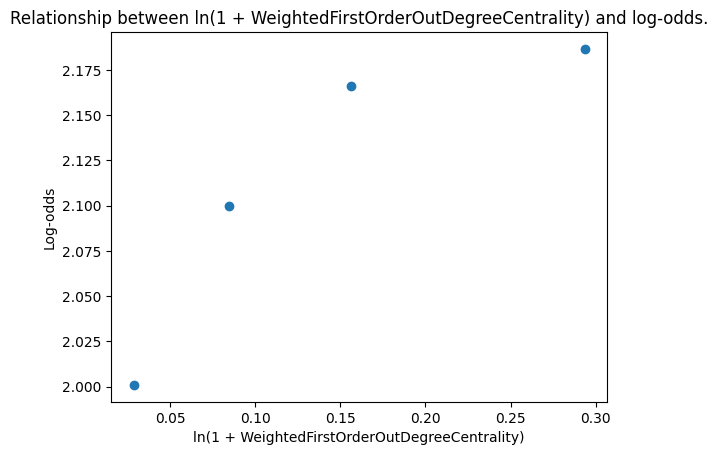

In [130]:
import regex as re
from numbers import Number
from typing import Callable, Iterator
import numpy as np
from python_proj.utils.util import tuple_chain


def test_log_linearity(
    independents: pd.DataFrame,
    dependent: pd.Series,
    transform_title: str = ""
):
    continuous_fields = independents.select_dtypes(include='number')

    all_data = pd.DataFrame()
    all_data[continuous_fields.columns] = continuous_fields.copy()
    all_data[pr_merged_key] = dependent.copy()

    for field in continuous_fields.columns:
        # Creates copy of the relevant fields.
        included = pd.DataFrame()
        included[field] = all_data[field].copy()
        included[pr_merged_key] = all_data[pr_merged_key].copy()

        # Removes data that will signifcantly skew the results.
        if re.match(r'.*SuccessRate.*', field):
            # TODO: Figure out what to do with success rate.
            # We can't properly test the log-linearity with the current data.
            # count_field = field[:-len('SuccessRate')] + "SubmissionCount"
            stripped_field = field[:-len('SuccessRate')]
            count_field = f'ln(1 + {stripped_field}SubmissionCount)'
            included[count_field] = all_data[count_field].copy()
            included = included[included[count_field] > 0]
            perc_quantiles = [0, 0.1, 0.25, 0.4, 0.5, 0.6, 0.75, 0.9, 1]
        else:
            included = included[included[field] > 0]
            perc_quantiles = [0, 0.25, 0.5, 0.75, 1]

        # Calculates quantiles.
        quantiles = included[field].quantile(perc_quantiles)
        print(f'{field}:')
        print(quantiles)
        print()

        x = []
        y = []
        skip_flag = False
        for r_start, r_end in tuple_chain(list(quantiles)):
            quant_data: pd.DataFrame = included[(
                included[field] >= r_start) & (included[field] <= r_end)]
            # quant_mean = quant_data[field].mean()
            quant_mean = quant_data[field].median()
            merged_entries = quant_data[quant_data[pr_merged_key] == True]
            probability = len(merged_entries) / len(quant_data)
            if probability == 1:
                skip_flag = True
                break
            log_odds = np.log(probability / (1 - probability))
            x.append(quant_mean)
            y.append(log_odds)

        if skip_flag:
            print(f'Skipped {field} because of division by zero.')
            continue

        print(f'{x=}, {y=}')

        plt.clf()
        plt.scatter(x, y)
        plt.title(f"Relationship between {field} and log-odds.")
        plt.xlabel(field)
        plt.ylabel("Log-odds")

        output_path = f'{figure_base_path}/log-odds-independence/{transform_title}/{field}'
        safe_save_fig(output_path)


def test_log_linearity_with_transforms(
    transforms: Iterator[Callable[[Number], Number]],
    independents: pd.DataFrame,
    dependent: pd.Series,
    figure_subfolder: str,
):
    continuous_fields = independents.select_dtypes(include='number')
    for transform in transforms:
        print(f"\n{transform.__name__}")
        transformed_independents = continuous_fields.copy()
        for field in transformed_independents.columns:
            transformed_independents[field] = transformed_independents[field]\
                .apply(transform)
            mn = transformed_independents[field].min()
            mx = transformed_independents[field].max()
            transformed_independents[field] = transformed_independents[field]\
                .apply(lambda x: (x - mn) / (mx - mn))
        test_log_linearity(transformed_independents,
                           dependent, f'{figure_subfolder}/{transform.__name__}')


def untransformed(value):
    return value


def ln_transform(value):
    return np.log(1 + value)


def sqrt_transform(value):
    return np.sqrt(1 + value)


def cbrt_transform(value):
    return np.cbrt(1 + value)


def reciprocal_transform(value):
    return 1 / (1 + value)


def squared_transform(value):
    return value ** 2


def ln_ln_transform(value):
    return np.log(1 + np.log(1 + value))


def ln_eps_transform(value):
    return np.log(0.1 + value)


def ln_eps_e2_transform(value):
    return np.log(0.01 + value)


def ln_eps_e3_transform(value):
    return np.log(0.001 + value)


def cubed_transform(value):
    return value ** 3


def ln_complement(value):
    return np.log(1.0 + (1.0 - value))


def ln_eps_complement(value):
    return np.log(0.001 + (1.0 - value))


def ln_eps_e5_complement(value):
    return np.log(0.00001 + (1.0 - value))


def compl_squared_compl(value):
    return 1.0 - ((1.0 - value) ** 2)


transforms = [
    untransformed,
    # ln_transform,
    # sqrt_transform,
    # cbrt_transform,
    # reciprocal_transform,
    # ln_complement,
    # ln_eps_complement,
    # compl_squared_compl,
    # squared_transform,
    # cubed_transform,
    # ln_ln_transform,
    # ln_eps_e2_transform,
    # ln_eps_e3_transform,
    # ln_eps_e5_complement
]


# Full model.
independents = df[independent_fields]
dependent = df[pr_merged_key]
test_log_linearity_with_transforms(
    transforms, independents, dependent, "dependency_model")


## Box-Tidwill Test

In [131]:
import statsmodels.api as sm


def box_tidwill_test(
    independents: pd.DataFrame(),
    dependent: pd.Series()
):
    continuous_fields = independents.select_dtypes(include='number')

    ln_field = f'ln(x) * x'
    for field in continuous_fields:
        test_independents = independents[[field]].copy()
        # TODO: Can you do this?! the ``1 + x`` thing?
        test_independents[ln_field] = test_independents[field]\
            .apply(lambda x: np.log(0.0001 + x) * (0.0001 + + x))
        test_independents = sm.add_constant(test_independents)

        logit_model = sm.Logit(dependent,
                               test_independents).fit()

        p_value = logit_model.pvalues[ln_field]
        is_significant = p_value < 0.05

        test_result = "failed" if is_significant else "passed"
        print(f'{field} {test_result} with {p_value=:.05f}.')


independents: pd.DataFrame = df[independent_fields]
dependent: pd.Series = df[pr_merged_key]
box_tidwill_test(independents, dependent)


Optimization terminated successfully.
         Current function value: 0.321477
         Iterations 7
IntraProjectSubmitterPullRequestSuccessRate failed with p_value=0.00000.
Optimization terminated successfully.
         Current function value: 0.333341
         Iterations 6
EcosystemExperienceSubmitterPullRequestSuccessRate failed with p_value=0.00000.
Optimization terminated successfully.
         Current function value: 0.340444
         Iterations 7
DependencyEcosystemExperienceSubmitterPullRequestSuccessRate failed with p_value=0.00000.
Optimization terminated successfully.
         Current function value: 0.343632
         Iterations 7
InversedDependencyEcosystemExperienceSubmitterPullRequestSuccessRate failed with p_value=0.00000.
Optimization terminated successfully.
         Current function value: 0.307526
         Iterations 7
ln(1 + ControlPullRequestLifeTimeInMinutes) failed with p_value=0.00000.
Optimization terminated successfully.
         Current function value: 0.345

## Multicolinearity


In [132]:

multicollinear_fields = [
    # Ignored field.
    "SubmitterIsFirstTimeContributor",
    
    # ### Control cluster.
    # "ControlPullRequestHasCommentByExternalUser",
    "ControlPullRequestHasComments",

    # ### Cluster: Dependency issues.
    # "ln(1 + DependencyEcosystemExperienceSubmitterIssueSubmissionCount)",
    "ln(1 + DependencyEcosystemExperienceSubmitterIssueCommentCount)",
    
    # ### Cluster: fo-degree centrality
    # "ln(1 + WeightedFirstOrderInDegreeCentrality)",
    "ln(1 + WeightedFirstOrderOutDegreeCentrality)",

    # ### Cluster: dependency eco PR
    # "DependencyEcosystemExperienceSubmitterPullRequestSuccessRate",
    "ln(1 + DependencyEcosystemExperienceSubmitterPullRequestSubmissionCount)",
    # "ln(1 + DependencyEcosystemExperienceSubmitterPullRequestCommentCount)",

    # ### Cluster: Intra-project experience.
    # "ln(1 + ControlIntraProjectPullRequestExperienceOfIntegrator)",
    "ln(1 + IntraProjectSubmitterPullRequestSubmissionCount)",
    "ln(1 + IntraProjectSubmitterPullRequestCommentCount)",
    # "ln(1 + IntraProjectSubmitterIssueSubmissionCount)",
    "ln(1 + IntraProjectSubmitterIssueCommentCount)",

    # ### Cluster: ecosystem experience
    # "ln(1 + EcosystemExperienceSubmitterPullRequestSubmissionCount)",
    "ln(1 + EcosystemExperienceSubmitterPullRequestCommentCount)",
    "ln(1 + EcosystemExperienceSubmitterIssueSubmissionCount)",
    "ln(1 + EcosystemExperienceSubmitterIssueCommentCount)",

    # ### Cluster: Inversed dependency experience.
    "InversedDependencyEcosystemExperienceSubmitterPullRequestSuccessRate",
    # "ln(1 + InversedDependencyEcosystemExperienceSubmitterPullRequestSubmissionCount)",
    "ln(1 + InversedDependencyEcosystemExperienceSubmitterPullRequestCommentCount)",
    "ln(1 + InversedDependencyEcosystemExperienceSubmitterIssueSubmissionCount)",
    "ln(1 + InversedDependencyEcosystemExperienceSubmitterIssueCommentCount)",

    ### Cluster: 
    # "ControlIntegratedBySameUser",
    "ln(1 + SharedExperiencePullRequestSubmittedBySubmitterIntegratedByIntegrator)",
    # "ln(1 + SharedExperiencePullRequestSubmittedByIntegratorIntegratedBySubmitter)",
    "ln(1 + SharedExperiencePullRequestSubmittedBySubmitterCommentedOnByIntegrator)",
    "ln(1 + SharedExperiencePullRequestSubmittedByIntegratorCommentedOnBySubmitter)",
    "ln(1 + SharedExperienceIssueSubmittedBySubmitterCommentedOnByIntegrator)",
    "ln(1 + SharedExperiencePullRequestDiscussionParticipationByIntegratorAndSubmitter)",
    "ln(1 + SharedExperienceIssueSubmittedByIntegratorCommentedOnBySubmitter)",
    "ln(1 + SharedExperienceIssueDiscussionParticipationByIntegratorAndSubmitter)",
]

print(f'Removing {len(multicollinear_fields)} / {len(independent_fields)} fields to account for multicollinearity.')


Removing 22 / 38 fields to account for multicollinearity.


In [133]:
from statsmodels.stats.outliers_influence import variance_inflation_factor


def change_bin_fields_to_float(__df: pd.DataFrame):
    repl_df = __df.copy()
    value_mapper = {False: 0, True: 1}

    binary_fields = __df.select_dtypes(exclude='number')
    for feature in binary_fields:
        repl_df[feature] = __df[feature].replace(value_mapper)

    return repl_df


tested_predictors = df[independent_fields].drop(multicollinear_fields, axis=1)
tested_predictors = change_bin_fields_to_float(tested_predictors)

vif_df = pd.DataFrame()
vif_df['variable'] = tested_predictors.columns
vif_df['VIF'] = [variance_inflation_factor(tested_predictors.values, i)
                 for i in range(tested_predictors.shape[1])]

print(vif_df)


                                             variable        VIF
0                         ControlIntegratedBySameUser   3.628877
1                      ControlHasHashTagInDescription   1.610935
2         IntraProjectSubmitterPullRequestSuccessRate   5.927009
3   EcosystemExperienceSubmitterPullRequestSuccess...  10.540256
4   DependencyEcosystemExperienceSubmitterPullRequ...   3.590625
5          ControlPullRequestHasCommentByExternalUser   1.399223
6         ln(1 + ControlPullRequestLifeTimeInMinutes)   4.091985
7         ln(1 + ControlNumberOfCommitsInPullRequest)   4.081919
8   ln(1 + ControlIntraProjectPullRequestExperienc...   6.081697
9   ln(1 + SharedExperiencePullRequestSubmittedByI...   1.302210
10  ln(1 + EcosystemExperienceSubmitterPullRequest...   8.145723
11  ln(1 + DependencyEcosystemExperienceSubmitterP...   2.782775
12  ln(1 + InversedDependencyEcosystemExperienceSu...   1.968955
13  ln(1 + IntraProjectSubmitterIssueSubmissionCount)   2.096420
14  ln(1 + DependencyEcos

In [134]:
problematic_vif = vif_df[vif_df['VIF'] >= 5]
print(f"Problematic VIF fields: {len(problematic_vif)}.")
print("Problematic VIF scores:")
print(problematic_vif)


Problematic VIF fields: 4.
Problematic VIF scores:
                                             variable        VIF
2         IntraProjectSubmitterPullRequestSuccessRate   5.927009
3   EcosystemExperienceSubmitterPullRequestSuccess...  10.540256
8   ln(1 + ControlIntraProjectPullRequestExperienc...   6.081697
10  ln(1 + EcosystemExperienceSubmitterPullRequest...   8.145723


coof_threshold=0.5
Correlating pairs:
[]

Variable correlation frequency:
[]

Transitive closure of correlating pairs:
[
    []
]


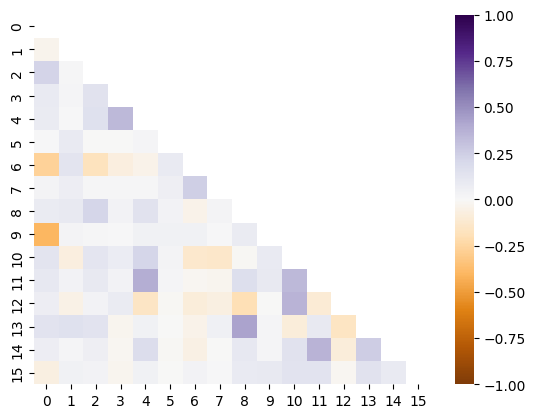

In [135]:
import seaborn as sb
import json
from python_proj.utils.util import SafeDict

tick_labels = list(range(len(vif_df)))
corr = tested_predictors.corr(method='spearman')

rows, cols = corr.shape
mask = np.invert(np.tril(np.ones((rows, cols), dtype=bool), k=-1))
dataplot = sb.heatmap(corr, cmap="PuOr",
                      xticklabels=tick_labels, yticklabels=tick_labels,
                      mask=mask,
                      vmin=-1, vmax=1)


def get_correlating_fields(coof_threshold, corr):
    print(f'{coof_threshold=}')
    correlating_fields = []
    # print(corr)
    for rowIndex, row in corr.iterrows():  # iterate over rows
        for columnIndex, coof in row.items():
            if columnIndex <= rowIndex:
                continue
            if abs(coof) < coof_threshold:
                continue
            correlating_fields.append([columnIndex, rowIndex, coof])
    correlating_fields = [list(entry) for entry in correlating_fields]
    print("Correlating pairs:\n" + json.dumps(correlating_fields, indent=4) + "\n")
    return correlating_fields


correlating_fields = get_correlating_fields(coof_threshold=0.5, corr=corr)

# Identify problematic fields:
presence_counts = SafeDict(default_value=0)
for (field_a, field_b, _) in correlating_fields:
    presence_counts[field_a] += 1
    presence_counts[field_b] += 1
pc = list(presence_counts.items())
pc.sort(key=lambda x: x[1])
print(f'Variable correlation frequency:\n{json.dumps(pc, indent=4)}\n')

# Generate transitive closures


def unify_if_overlapping(collections: list[list]):
    # gather the lists that do overlap
    overlapping = [x for x in collections if
                   any(x_element in [y for k in collections
                                     if k != x for y in k]
                       for x_element in x)]
    # flatten and get unique
    overlapping = sorted(list(set([z for x in overlapping for z in x])))
    # get the rest
    non_overlapping = [x for x in collections if all(
        y not in overlapping for y in x)]
    # use the line bellow only if merged non-overlapping elements are desired
    # non_overlapping = sorted([y for x in non_overlapping for y in x])
    non_overlapping.append(overlapping)
    return non_overlapping


correlating_no_coof = [(a, b) for (a, b, _) in correlating_fields]
unified = unify_if_overlapping(correlating_no_coof)
print("Transitive closure of correlating pairs:\n" +
      json.dumps(unified, indent=4))


Plots a graph when there are correlating fields.


In [136]:
import networkx as nx
import matplotlib.pyplot as plt

if len(correlating_fields) > 0:
    fields = list(tested_predictors.columns)
    enumerated_list = list(enumerate(fields))
    ids = []
    edge_colors = []
    for source, target, coof in correlating_fields:
        source_idx = fields.index(source)
        target_idx = fields.index(target)
        ids.append((source_idx, target_idx))
        edge_colors.append('red' if coof < 0 else 'green')

    # Create an empty graph
    graph = nx.Graph()

    # Add edges to the graph from the list of tuples
    graph.add_edges_from(ids)

    pos = nx.spring_layout(graph, k=0.4)
    nx.draw(graph, pos, with_labels=True, edge_color=edge_colors)
    
    output_path = f'{figure_base_path}/correlating_fields.png'
    safe_save_fig(output_path)

    print(json.dumps(enumerated_list))


In [137]:
print(f'{len(tested_predictors.columns)=}')
print(f'{tested_predictors.columns=}')


len(tested_predictors.columns)=16
tested_predictors.columns=Index(['ControlIntegratedBySameUser', 'ControlHasHashTagInDescription',
       'IntraProjectSubmitterPullRequestSuccessRate',
       'EcosystemExperienceSubmitterPullRequestSuccessRate',
       'DependencyEcosystemExperienceSubmitterPullRequestSuccessRate',
       'ControlPullRequestHasCommentByExternalUser',
       'ln(1 + ControlPullRequestLifeTimeInMinutes)',
       'ln(1 + ControlNumberOfCommitsInPullRequest)',
       'ln(1 + ControlIntraProjectPullRequestExperienceOfIntegrator)',
       'ln(1 + SharedExperiencePullRequestSubmittedByIntegratorIntegratedBySubmitter)',
       'ln(1 + EcosystemExperienceSubmitterPullRequestSubmissionCount)',
       'ln(1 + DependencyEcosystemExperienceSubmitterPullRequestCommentCount)',
       'ln(1 + InversedDependencyEcosystemExperienceSubmitterPullRequestSubmissionCount)',
       'ln(1 + IntraProjectSubmitterIssueSubmissionCount)',
       'ln(1 + DependencyEcosystemExperienceSubmitterIssue

## Outliers

Using cook's distance.


In [138]:
import statsmodels.api as sm
import scipy

X_constant = sm.add_constant(tested_predictors)

# Use GLM method for logreg here so that we can retrieve the influence measures
logit_results = sm.GLM(df[pr_merged_key], X_constant,
                       family=sm.families.Binomial()).fit()

# Get influence measures
influence = logit_results.get_influence()

# Obtain summary df of influence measures
summ_df = influence.summary_frame()

# Filter summary df to Cook's distance values only
diagnosis_df = summ_df[['cooks_d']]

# Set Cook's distance threshold
cook_threshold = 4 / len(tested_predictors)

# Append absolute standardized residual values
diagnosis_df['std_resid'] = scipy.stats.zscore(logit_results.resid_pearson)
diagnosis_df['std_resid'] = diagnosis_df['std_resid'].apply(
    lambda x: np.abs(x))

# Find observations which are BOTH outlier (std dev > 3) and highly influential
extreme = diagnosis_df[(diagnosis_df['cooks_d'] > cook_threshold) &
                       (diagnosis_df['std_resid'] > 3)]


# Show top 5 highly influential outlier observations
extreme.sort_values("cooks_d", ascending=False).head(10)


/tmp/ipykernel_778/2490181039.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  diagnosis_df['std_resid'] = scipy.stats.zscore(logit_results.resid_pearson)
/tmp/ipykernel_778/2490181039.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  diagnosis_df['std_resid'] = diagnosis_df['std_resid'].apply(


,cooks_d,std_resid
94059,0.000702,4.518350
93244,0.000701,4.073377
79649,0.000525,8.022498
97834,0.000436,4.136047
146245,0.000431,8.235579
146480,0.000428,7.239841
93799,0.000422,6.711259
97150,0.000410,3.952404
96122,0.000408,4.834964
5102,0.000406,19.511226


1.792387729313605e-05
Found outliers: 5620 / 223183 (2.518%)


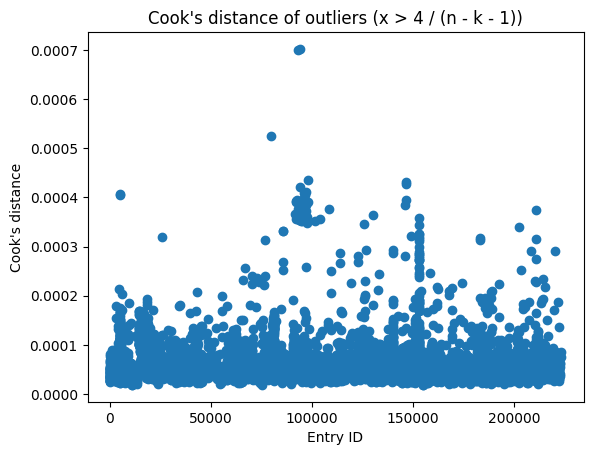

In [139]:
cook_threshold = 4 / (len(tested_predictors) -
                      len(tested_predictors.columns) - 1)
print(cook_threshold)
print(
    f'Found outliers: {len(extreme)} / {len(tested_predictors)} ({100 * len(extreme)/len(tested_predictors):.03f}%)')

plt.title("Cook's distance of outliers (x > 4 / (n - k - 1))")
plt.scatter(extreme.index, extreme['cooks_d'])
plt.xlabel("Entry ID")
plt.ylabel("Cook's distance")

output_path = f'{figure_base_path}/cooks_outliers.png'
safe_save_fig(output_path)


Removes outliers

In [140]:
tested_predictors = tested_predictors.drop(extreme.index)
tested_dependents = dependent.drop(extreme.index)

print(f'{len(tested_predictors)=}')

len(tested_predictors)=217563


# Model Creation

Creates a simple mixed effect logistic regression model.

In [141]:
from statsmodels.regression.mixed_linear_model import MixedLM

# Selects relevant project names.
pn_key = "Project Name"
tested_projects = df[pn_key].copy()
tested_projects = tested_projects[tested_predictors.index]

# Creates model.
mixed_model = MixedLM(
    tested_dependents,
    tested_predictors,
    tested_projects,
).fit()

mixed_model.summary()


<class 'statsmodels.iolib.summary2.Summary'>
"""
                                            Mixed Linear Model Regression Results
=============================================================================================================================
Model:                                MixedLM                     Dependent Variable:                     PullRequestIsMerged
No. Observations:                     217563                      Method:                                 REML               
No. Groups:                           8460                        Scale:                                  0.0515             
Min. group size:                      1                           Log-Likelihood:                         -4825.2864         
Max. group size:                      661                         Converged:                              Yes                
Mean group size:                      25.7                                                                                   
-----------------------------------------------------------------------------------------------------------------------------
                                                                                 Coef.  Std.Err.    z     P>|z| [0.025 0.975]
-----------------------------------------------------------------------------------------------------------------------------
ControlIntegratedBySameUser                                                      -0.060    0.001  -41.181 0.000 -0.063 -0.057
ControlHasHashTagInDescription                                                    0.014    0.001   11.404 0.000  0.011  0.016
IntraProjectSubmitterPullRequestSuccessRate                                      -0.006    0.002   -3.711 0.000 -0.009 -0.003
EcosystemExperienceSubmitterPullRequestSuccessRate                                0.137    0.002   56.107 0.000  0.133  0.142
DependencyEcosystemExperienceSubmitterPullRequestSuccessRate                      0.007    0.002    4.375 0.000  0.004  0.010
ControlPullRequestHasCommentByExternalUser                                        0.015    0.002    9.874 0.000  0.012  0.018
ln(1 + ControlPullRequestLifeTimeInMinutes)                                      -0.334    0.003 -111.063 0.000 -0.340 -0.328
ln(1 + ControlNumberOfCommitsInPullRequest)                                       0.314    0.008   37.432 0.000  0.298  0.331
ln(1 + ControlIntraProjectPullRequestExperienceOfIntegrator)                      1.225    0.006  205.462 0.000  1.213  1.236
ln(1 + SharedExperiencePullRequestSubmittedByIntegratorIntegratedBySubmitter)    -0.032    0.007   -4.722 0.000 -0.045 -0.019
ln(1 + EcosystemExperienceSubmitterPullRequestSubmissionCount)                   -0.015    0.005   -3.208 0.001 -0.025 -0.006
ln(1 + DependencyEcosystemExperienceSubmitterPullRequestCommentCount)             0.012    0.004    2.703 0.007  0.003  0.020
ln(1 + InversedDependencyEcosystemExperienceSubmitterPullRequestSubmissionCount)  0.017    0.006    3.032 0.002  0.006  0.028
ln(1 + IntraProjectSubmitterIssueSubmissionCount)                                -0.238    0.006  -43.010 0.000 -0.248 -0.227
ln(1 + DependencyEcosystemExperienceSubmitterIssueSubmissionCount)                0.018    0.006    2.867 0.004  0.006  0.031
ln(1 + WeightedFirstOrderInDegreeCentrality)                                      0.005    0.005    0.957 0.338 -0.005  0.016
Group Var                                                                         0.524    0.041                             
=============================================================================================================================

"""